In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv('pro_news_classifier.csv')

In [3]:
df.head()

,Unnamed: 0,title,class
0,2626,Trump Loses His Sh*t After Nordstrom Stops Pe...,0
1,13622,South Korea's Moon says North Korea missile ca...,1
2,20256,"Hezbollah declares Syria victory, Russia says ...",1
3,11503,Two Palestinians killed in anti-US protests af...,1
4,14276,HUCKABEE : ‘Hillary Is In for the Ride of Her ...,0


In [4]:
df = df.drop(['Unnamed: 0'], axis=1)

In [58]:
df['title'][1]

'south koreas moon says north korea missile capability seems improved'

In [163]:
df['title'][0]

'trump loses his sht after nordstrom stops peddling ivankas shtty product line'

In [5]:
df.isnull().sum()

title    0
class    0
dtype: int64

In [6]:
df.dtypes

title    object
class     int64
dtype: object

In [7]:
import preprocess_kgptalkie as ps
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [8]:
df['title']=df['title'].apply(lambda x: get_clean(x))

In [9]:
tokenizer = Tokenizer(num_words=5000, split=" ")

In [10]:
tokenizer.fit_on_texts(df['title'].values)

In [11]:
X = tokenizer.texts_to_sequences(df['title'].values)

In [12]:
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    2,  800,   28,
         881,   15, 4403, 2469, 4838,  716],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  135,
         969, 2470,   13,   49,   64,  486],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 2060, 1168,  128,  677,   43,
          13,  620,    5,  464, 1188,   94],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

In [13]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 256)           1280000   
_________________________________________________________________
dropout (Dropout)            (None, 39, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 39, 256)           525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 39, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 5

In [15]:
y = pd.get_dummies(df['class']).values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [17]:
batch_size = 64
epochs = 5

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test,y_test))

Epoch 1/5
562/562 [==============================] - 230s 378ms/step - loss: 0.2536 - accuracy: 0.8837 - val_loss: 0.1054 - val_accuracy: 0.9622
Epoch 2/5
562/562 [==============================] - 227s 405ms/step - loss: 0.0849 - accuracy: 0.9692 - val_loss: 0.0937 - val_accuracy: 0.9655
Epoch 3/5
562/562 [==============================] - 216s 385ms/step - loss: 0.0581 - accuracy: 0.9789 - val_loss: 0.0976 - val_accuracy: 0.9638
Epoch 4/5
562/562 [==============================] - 230s 409ms/step - loss: 0.0403 - accuracy: 0.9862 - val_loss: 0.1113 - val_accuracy: 0.9655
Epoch 5/5
562/562 [==============================] - 235s 419ms/step - loss: 0.0318 - accuracy: 0.9889 - val_loss: 0.1078 - val_accuracy: 0.9636


In [21]:
import matplotlib.pyplot as plt 

def plot_graph(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' +metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.16829153280705214)

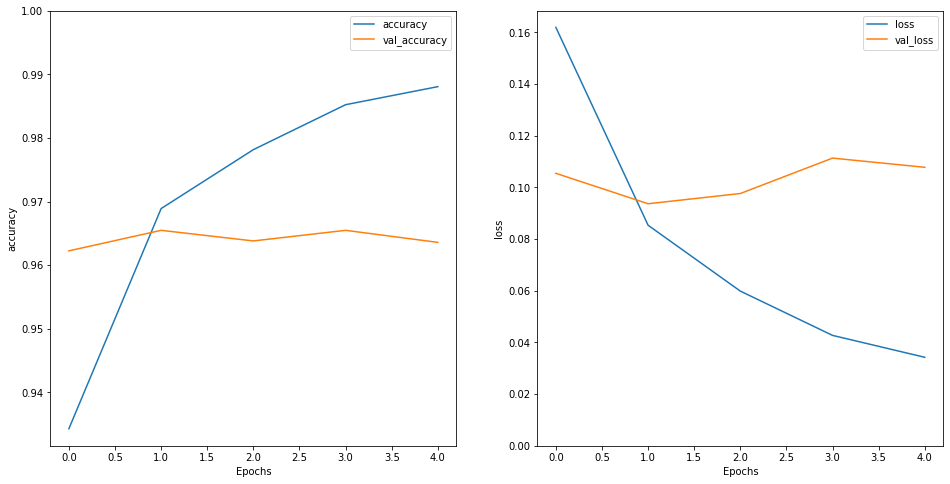

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graph(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graph(history, 'loss')
plt.ylim(0, None)

In [23]:
model.save('fake_news_detedctor.h5')

In [185]:
x = 'south koreas moon says north korea missile capability seems improved'
# x = 'trump loses his sht after nordstrom stops peddling ivankas shtty product line'
# x = 'Rahul won the election by 2 votes'
x = get_clean(x)
tokenizer.fit_on_texts(x)

In [186]:
x = tokenizer.texts_to_sequences(x[:])

In [187]:
X = pad_sequences(x)

In [188]:
X = X.reshape(-1)
X

array([ 942, 1217, 3059, 1567, 2720,    0, 1088, 1217, 1928, 1426,   10,
        942,    0, 2538, 1217, 1217, 2065,    0,  942,   10, 3354,  942,
          0, 2065, 1217, 1928, 1567, 2720,    0, 1088, 1217, 1928, 1426,
         10,    0, 2538,  117,  942,  942,  117, 2413, 1426,    0, 3449,
         10, 3060,   10, 3740,  117, 2413,  117, 1567, 3354,    0,  942,
       1426, 1426, 2538,  942,    0,  117, 2538, 3060, 1928, 1217, 4957,
       1426, 3117], dtype=int32)

In [189]:
pred = model.predict_classes(X)

In [190]:
pred

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0])

In [191]:
pred = np.argmax(pred)
pred

1